In [1]:
! pip install kaggle
! mkdir ~/.kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#Portfolio Component: Image Classification

Using Keras and a dataset of images, we will generate different models based on the data as well as generating deep learning models using tensorflow. The data will be divided using a train/test 80/20, which then will be tested under different architectures such as RNN and CNN. 

The data set used for this component is from kaggle, which contains pictures taken by a satellite of clouds, water, desert, and forest. [Satellite Images Classification Dataset](https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification)

##Image Preprocessing

Before we can even run or even divide the data, we must first download the image dataset from kaggle via google colab with some packages and the api document required beforehand to allow the dataset to be downloaded. Once done, the image dataset can be preprocessed before the train/test split.

In [2]:
#import the necessary packages for image preprocessing
import tensorflow as tf
import pathlib
from google.colab import files

#Download data for image preprocessing (uncomment if it has not been downloaded)
! kaggle datasets download mahmoudreda55/satellite-image-classification

#Unzip the file
! unzip satellite-image-classification.zip

#Once downloaded, check how many images are in the data
data_dir = pathlib.Path('data').with_suffix('')
image_num = len(list(data_dir.glob('*/*.jpg')))
print("Number of images in dataset: ",image_num)

satellite-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  satellite-image-classification.zip
replace data/cloudy/train_10021.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Number of images in dataset:  5631


Having confirmed the number of images downloaded onto Google Colab from Kaggle, we can load these images off disk and process them for train/test.

##Train/Test Divide

First, we 
load the dataset of images and import the tensorflow package to begin dividing the dataset. Then, the data will be divided into the train/test (validation in keras) sets for building the model.

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#Defining some variables for loading off disk
batch_size = 32
imgHeight = 96
imgWidth = 96

train_img = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batch_size)

val_img = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_img)
test_seg = val_img.take(val_batches // 5)
val_img = val_img.skip(val_batches // 5)


Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


From here, we can visualize the data and plot a graph to see what can be predicted from the data, before training the data.

['cloudy', 'desert', 'green_area', 'water']
Image Shape in Train:  (32, 96, 96, 3)
Image Shape in Test:  (32, 96, 96, 3)


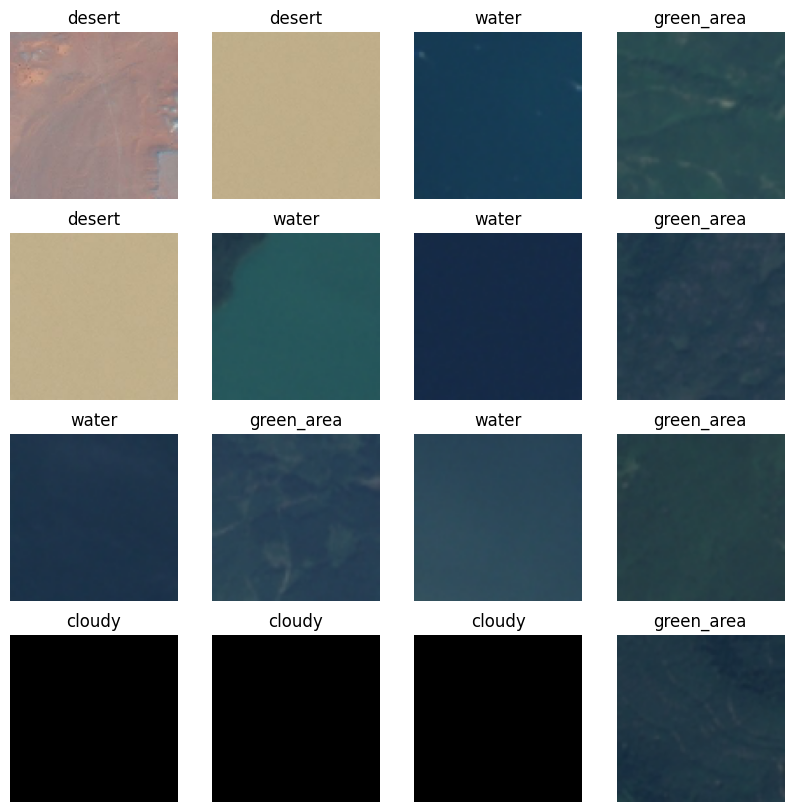

In [69]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#Listing the classes from the data
classes_img = train_img.class_names
print(classes_img)

for image_batch, labels_batch in train_img:
  IMG_SHAPE = image_batch.shape;
  print("Image Shape in Train: ", IMG_SHAPE)
  break

for image_batch, labels_batch in val_img:
  print("Image Shape in Test: ", image_batch.shape)
  break

#Create graphs and visualization data showing distribution of data

plt.figure(figsize=(10, 10))
for images, labels in train_img.take(2):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes_img[labels[i]])
    plt.axis("off")



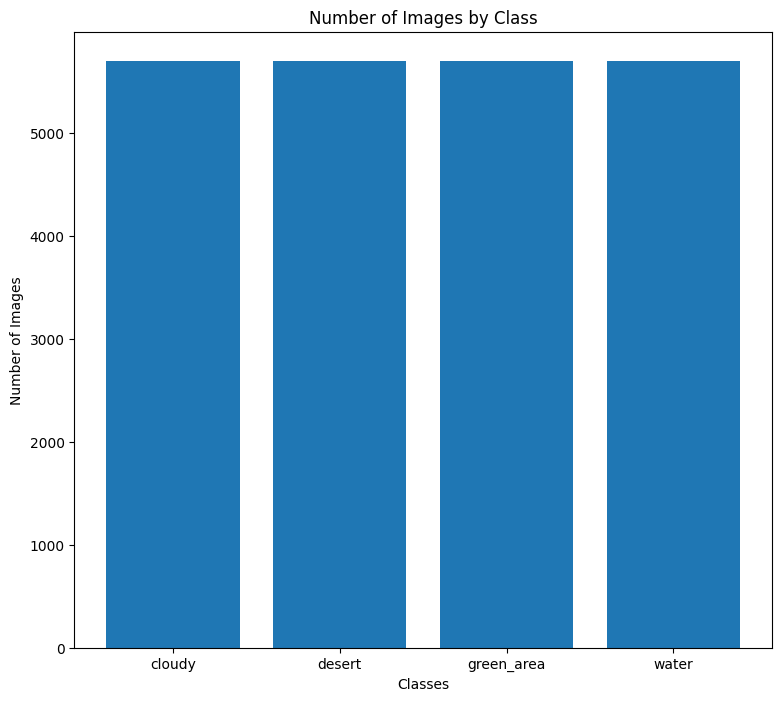

In [19]:
plt.figure(figsize=(9,8))
plt.xticks(np.arange(4))
plt.title("Number of Images by Class")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.bar(train_img.class_names, 5700)
plt.show()

Seeing some of the images, we will be focus on the prediction being able to distinguish between green_area images and water images, both being fairly close in color.

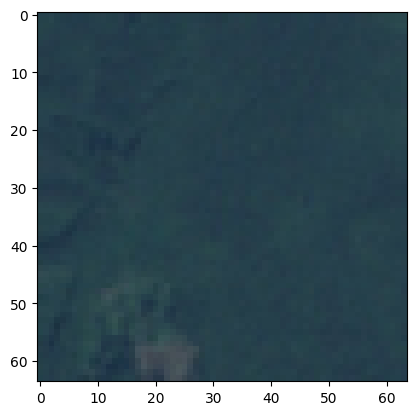

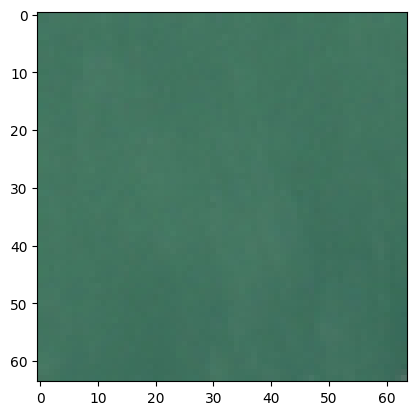

In [41]:
#Generating images comparing both green_area and water images
import imageio.v3 as iio

greenArea = iio.imread(uri="data/green_area/Forest_1404.jpg")
waterArea = iio.imread(uri="data/water/SeaLake_1009.jpg")


fig, ax = plt.subplots()
plt.imshow(greenArea)

fig, ax = plt.subplots()
plt.imshow(waterArea)

The dataset does seems to have an even distribution of images in the dataset. For this model, we will be predicting if the image can be identified as water images, from the other types of images, including green area images, which are close in color. 

##Modeling Data 

From here we will run a sequential model with the prediction being that will predict whether the image is an image of the water taken by the satellite or not. First, the data will have to be configured before bulding the sequential model.

In [70]:
#Configure for performance
AUTOTUNE = tf.data.AUTOTUNE

train_img = train_img.cache().prefetch(buffer_size=AUTOTUNE)
val_img = val_img.cache().prefetch(buffer_size=AUTOTUNE)
test_seg = test_seg.prefetch(buffer_size=AUTOTUNE)

Once done, we can then build a sequencial model and train/test it for accuracy based on the prediction that it will determine if the image is a green area image or not.

In [71]:
#Building the sequential model

num_classes = 4


model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.build(input_shape=(None, 96, 96, 3))
model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


history = model.fit(
  train_img,
  validation_data=val_img,
  epochs=10
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               7078144   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


141/141 [==============================] - 22s 148ms/step - loss: 1.2408 - accuracy: 0.7208 - val_loss: 0.3933 - val_accuracy: 0.7539
Epoch 2/10
141/141 [==============================] - 17s 124ms/step - loss: 0.3908 - accuracy: 0.7869 - val_loss: 0.2693 - val_accuracy: 0.8936
Epoch 3/10
141/141 [==============================] - 17s 119ms/step - loss: 0.4274 - accuracy: 0.7436 - val_loss: 0.3737 - val_accuracy: 0.7517
Epoch 4/10
141/141 [==============================] - 17s 117ms/step - loss: 0.3864 - accuracy: 0.7640 - val_loss: 0.3701 - val_accuracy: 0.7506
Epoch 5/10
141/141 [==============================] - 17s 118ms/step - loss: 0.3848 - accuracy: 0.7743 - val_loss: 0.3723 - val_accuracy: 0.7539
Epoch 6/10
141/141 [==============================] - 17s 120ms/step - loss: 0.3763 - accuracy: 0.8095 - val_loss: 0.2915 - val_accuracy: 0.8925
Epoch 7/10
141/141 [==============================] - 16s 116ms/step - loss: 0.3386 - accuracy: 0.8191 - val_loss: 0.2671 - val_accuracy: 0.9

Having trained the accuracy of the model, we can plot out the accuracy of 
the model itself between the train and test sets of the data. After ploting the model's accuracy, we can evaluate the model and print out the scores.

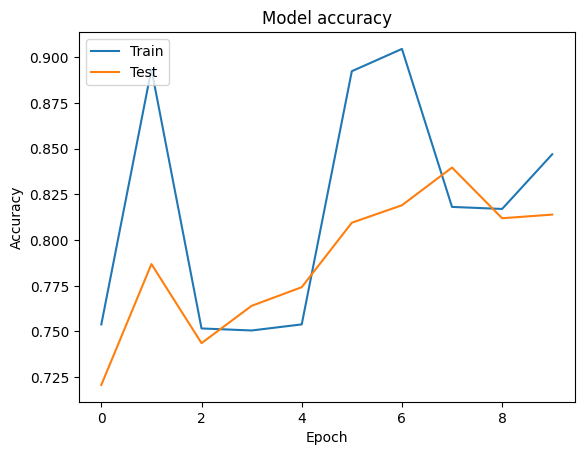

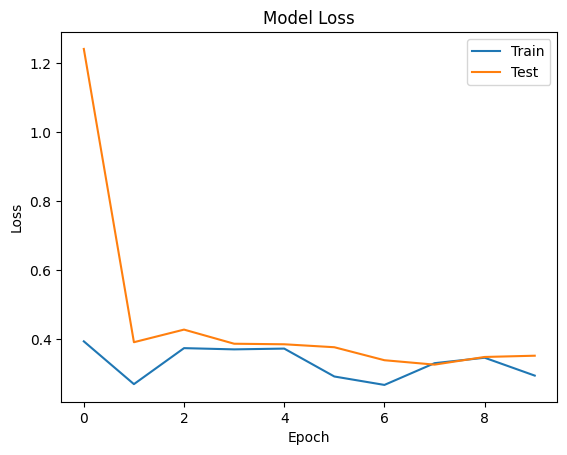

In [73]:
history.history.keys()

# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Evaluating and making a prediction using the sequential model.

In [86]:
from sklearn.metrics import classification_report

#Listing the classes from the data
classes_img = ['cloudy', 'desert', 'green_area', 'water']

#Evaluating Sequential Model
scores = model.evaluate(val_img, verbose=0)
print("Loss of Test: ", scores[0])
print("Accuracy of Test: ", scores[1])

#Prediction 
pred = model.predict(test_seg)
pred = np.argmax(pred, axis=1)
print(classes_img[pred[0]])


Loss of Test:  0.2940606474876404
Accuracy of Test:  0.8470066785812378
7/7 [==============================] - 0s 31ms/step
water


##More Modeling
We can try running the data with a different model to see how their results compare to the sequential model itself and how the method differs from the sequential model.

In [87]:
#CNN (Convolutional Neural Network)

num_classes = 4


model_cnn = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_cnn.build(input_shape=(None, 96, 96, 3))
model_cnn.summary()

model_cnn.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


history = model_cnn.fit(
  train_img,
  validation_data=val_img,
  epochs=7
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_406 (Conv2D)         (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_407 (Conv2D)         (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_408 (Conv2D)         (None, 20, 20, 32)       

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


141/141 [==============================] - 57s 397ms/step - loss: 0.3836 - accuracy: 0.8158 - val_loss: 0.4200 - val_accuracy: 0.7894
Epoch 2/7
141/141 [==============================] - 58s 409ms/step - loss: 0.2582 - accuracy: 0.8817 - val_loss: 0.2909 - val_accuracy: 0.8681
Epoch 3/7
141/141 [==============================] - 55s 392ms/step - loss: 0.2178 - accuracy: 0.9032 - val_loss: 0.1889 - val_accuracy: 0.9113
Epoch 4/7
141/141 [==============================] - 55s 393ms/step - loss: 0.1795 - accuracy: 0.9165 - val_loss: 0.2682 - val_accuracy: 0.8769
Epoch 5/7
141/141 [==============================] - 57s 400ms/step - loss: 0.1940 - accuracy: 0.9176 - val_loss: 0.1647 - val_accuracy: 0.9279
Epoch 6/7
141/141 [==============================] - 54s 382ms/step - loss: 0.1596 - accuracy: 0.9294 - val_loss: 0.1457 - val_accuracy: 0.9401
Epoch 7/7
141/141 [==============================] - 56s 398ms/step - loss: 0.1386 - accuracy: 0.9350 - val_loss: 0.1604 - val_accuracy: 0.9401


After building the CNN model, plot out the graph and see how it differs from the Sequential model.

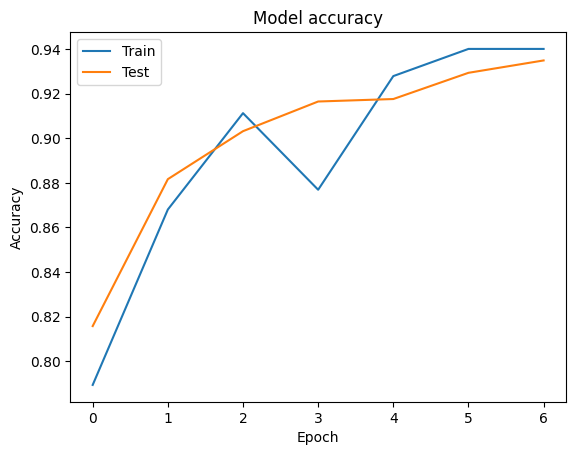

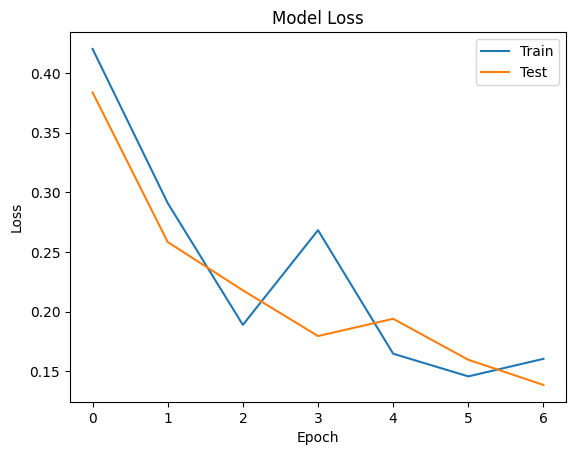

In [88]:
history.history.keys()

# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [91]:
#Evaluate and Predict using CNN model
scores = model_cnn.evaluate(val_img, verbose=0)
print("Loss: ", scores[0])
print("Accuracy: ", scores[1])

#Listing the classes from the data
classes_img = ['cloudy', 'desert', 'green_area', 'water']

#Prediction 
pred = model_cnn.predict(test_seg)
pred = np.argmax(pred, axis=1)
print(classes_img[pred[0]])

Loss:  0.16039538383483887
Accuracy:  0.9401330351829529
7/7 [==============================] - 1s 95ms/step
water


Next is the Recurrent Neural Network (RNN), to which the data's sequence is learned using its memory, state to learn sequences in data. Due to its vanishing gradient issue, the memory data path is kept independent of the back propagation path.
(This model does not work due to either the size of dataset or something in the model layers. No results were able to be produced.)

In [ ]:
from tensorflow.keras import datasets, layers, models, preprocessing

imageRNN_batch, labelRNN_batch = train_img.as_numpy_iterator().next()

# RNN (Recurrent Neural Network)
model_RNN = tf.keras.models.Sequential()
model_RNN.add(layers.Input(96,96))
model_RNN.add(layers.Flatten())
model_RNN.add(layers.Embedding(10000, 64))
model_RNN.add(layers.Bidirectional(
    layers.LSTM(64, return_sequences=True)))
model_RNN.add(layers.Bidirectional(layers.LSTM(64)))
model_RNN.add(layers.Dense(64, activation="relu"))
model_RNN.add(layers.Dropout(0.4))
model_RNN.add(layers.Dense(1, activation="softmax"))

model_RNN.summary()

model_RNN.compile(
  optimizer='rmsprop',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


history = model_RNN.fit(
  train_img,
  validation_data=val_img,
  epochs=3)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (128, 128)                0         
                                                                 
 embedding_14 (Embedding)    (128, 128, 64)            640000    
                                                                 
 bidirectional_19 (Bidirecti  (128, 128, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_20 (Bidirecti  (128, 128)               98816     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (128, 64)                 8256      
                                                                 
 dropout_12 (Dropout)        (128, 64)               

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [ ]:
history.history.keys()

# Plot training & validation accuracy values
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
#Evaluate and Predict using CNN model
scores = model_RNN.evaluate(val_img, verbose=0)
print("Loss: ", scores[0])
print("Accuracy: ", scores[1])

#Listing the classes from the data
classes_img = ['cloudy', 'desert', 'green_area', 'water']

#Prediction 
pred = model_RNN.predict(test_seg)
pred = np.argmax(pred, axis=1)
print(classes_img[pred[0]])

##Transferred Learning

Rather than start from scratch, one can instead use a pretrained model from another dataset to help in learning and improving the performance of the models. This requires modifying the layers of the pretrained model to fit in and adapt it to the given data.

In [92]:
# Pulling in the pretrained model from Keras
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
model_pretrained = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3))

model_pretrained.summary()


Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_13[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

In [93]:

image_batch, label_batch = next(iter(train_img))
feature_batch = model_pretrained(image_batch)
print(feature_batch.shape)


(32, 3, 3, 1280)


In [ ]:
# Adding data augmentation for reducing overfitting
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Having the pretrained model downloaded, we now need to freeze the vase and add our own layers. Freezing the base will prevent any updates from coming in during training.

In [96]:
# Freezing 
model_pretrained.trainable = False


In [97]:
#Classification head for generating predictions
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [98]:
#Converting features into one single prediction layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now, we can build the model with the addition of our own data layer included in the model.

In [104]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = model_pretrained(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_newTrain = tf.keras.Model(inputs, outputs)

In [105]:
base_learning_rate = 0.0001
model_newTrain.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [106]:
model_newTrain.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_6 (Sequential)   (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                           

##Training Model from Pretrained Dataset

With the new model build, we can begin training it and fine-tuning the model to make any improvements to be able to make good predictions.

In [107]:
initial_epochs = 10

lossTransfer, accuracyTransfer = model_newTrain.evaluate(val_img)

29/29 [==============================] - 8s 173ms/step - loss: 1.7111 - accuracy: 0.2417


In [108]:
print("initial loss: {:.2f}".format(lossTransfer))
print("initial accuracy: {:.2f}".format(accuracyTransfer))

initial loss: 1.71
initial accuracy: 0.24


In [110]:
history = model_newTrain.fit(train_img,
                    epochs=initial_epochs,
                    validation_data=val_img)

Epoch 1/10
141/141 [==============================] - 37s 261ms/step - loss: -1.1751 - accuracy: 0.2613 - val_loss: -2.6406 - val_accuracy: 0.2217
Epoch 2/10
141/141 [==============================] - 38s 269ms/step - loss: -3.7645 - accuracy: 0.1973 - val_loss: -5.1941 - val_accuracy: 0.2217
Epoch 3/10
141/141 [==============================] - 37s 261ms/step - loss: -6.2648 - accuracy: 0.1945 - val_loss: -7.8324 - val_accuracy: 0.2217
Epoch 4/10
141/141 [==============================] - 37s 261ms/step - loss: -8.9047 - accuracy: 0.1942 - val_loss: -10.5330 - val_accuracy: 0.2217
Epoch 5/10
141/141 [==============================] - 39s 279ms/step - loss: -11.5442 - accuracy: 0.1942 - val_loss: -13.2761 - val_accuracy: 0.2217
Epoch 6/10
141/141 [==============================] - 37s 263ms/step - loss: -14.2827 - accuracy: 0.1942 - val_loss: -16.0574 - val_accuracy: 0.2217
Epoch 7/10
141/141 [==============================] - 38s 268ms/step - loss: -16.9821 - accuracy: 0.1942 - val_lo

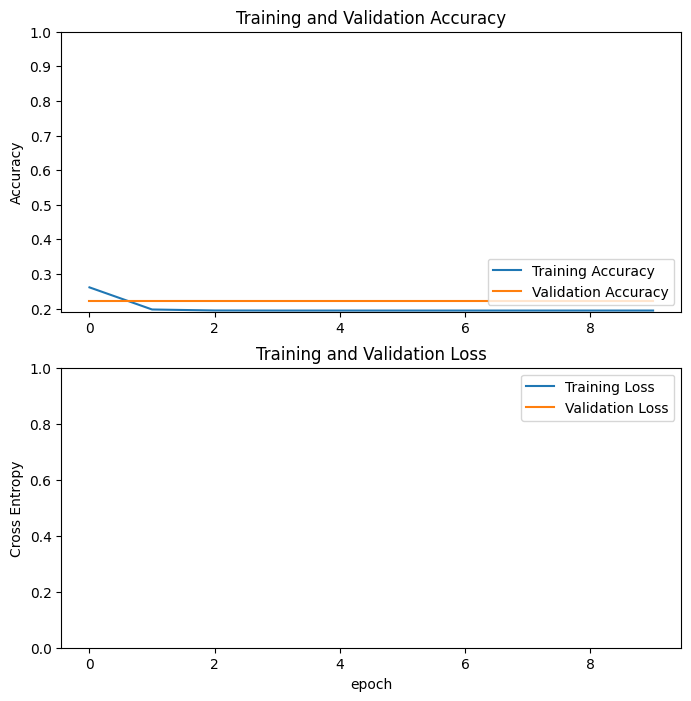

In [112]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Having done the initial running of the model and seeing the current metrics of the training, we will begin fine-tuning the model by updating the weights of the model. To do so, the layers will need to be unfrozen.

In [113]:
#Unfreeze the model
model_pretrained.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model_pretrained.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model_pretrained.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


Recompile the model and retrain it to see improvements in the model data.

In [114]:
model_newTrain.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model_newTrain.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential_6 (Sequential)   (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 96, 96, 3)        0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                           

In [115]:
#Training the fine-tuned model
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_newTrain.fit(train_img,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_img)

Epoch 10/20
141/141 [==============================] - 82s 530ms/step - loss: -304.3424 - accuracy: 0.3274 - val_loss: -403.9481 - val_accuracy: 0.4612
Epoch 11/20
141/141 [==============================] - 76s 536ms/step - loss: -412.6069 - accuracy: 0.4637 - val_loss: -420.6570 - val_accuracy: 0.4612
Epoch 12/20
141/141 [==============================] - 77s 547ms/step - loss: -421.9451 - accuracy: 0.4666 - val_loss: -427.6558 - val_accuracy: 0.4612
Epoch 13/20
141/141 [==============================] - 77s 549ms/step - loss: -428.8111 - accuracy: 0.4677 - val_loss: -434.5661 - val_accuracy: 0.4612
Epoch 14/20
141/141 [==============================] - 77s 545ms/step - loss: -435.4622 - accuracy: 0.4659 - val_loss: -441.4782 - val_accuracy: 0.4612
Epoch 15/20
141/141 [==============================] - 71s 501ms/step - loss: -442.4204 - accuracy: 0.4677 - val_loss: -448.3989 - val_accuracy: 0.4612
Epoch 16/20
141/141 [==============================] - 69s 492ms/step - loss: -449.6003 

Plot out the updated learning curve graphs

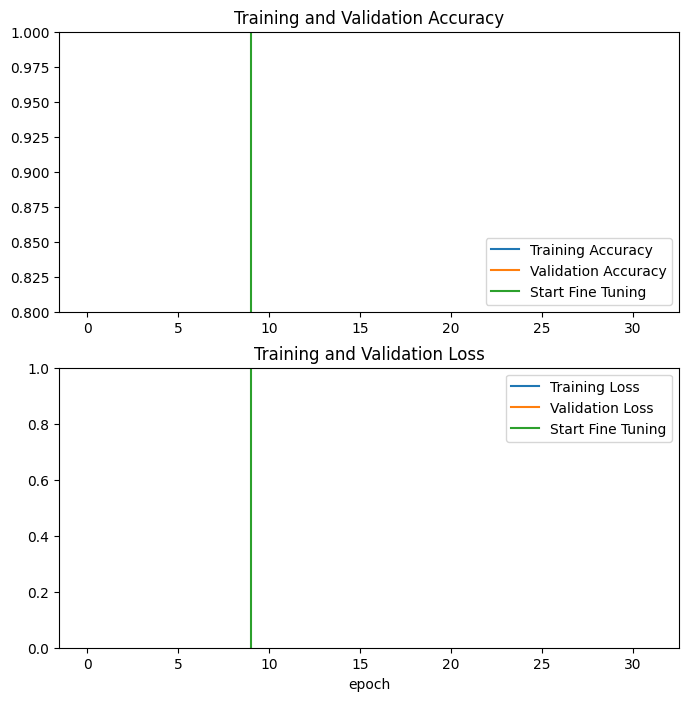

In [118]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Predictions

The model can now be evaluated before making predictions, to see how it compares to the test data. Once that is done, we can begin to predict

In [119]:
#Creating a testing dataset
val_batches = tf.data.experimental.cardinality(val_img)
test_img = val_img.take(val_batches // 5)
val_img = val_img.skip(val_batches // 5)

test_img = test_img.prefetch(buffer_size=AUTOTUNE)

loss_test, accuracy_test = model_newTrain.evaluate(test_img)
print('Test accuracy :', accuracy_test)


4/4 [==============================] - 1s 329ms/step - loss: -586.8119 - accuracy: 0.3516
Test accuracy : 0.3515625


4/4 [==============================] - 2s 175ms/step
cloudy
Predictions:
 [3 3 3 2 3 3 3 3 3 2 3 2 2 3 3 3 3 3 3 2 3 2 3 2 3 3 3 3 3 3 3 3]
Labels:
 [2 3 1 0 2 2 3 2 3 0 1 0 0 2 3 3 3 2 3 0 1 0 2 0 3 1 2 3 2 3 1 3]


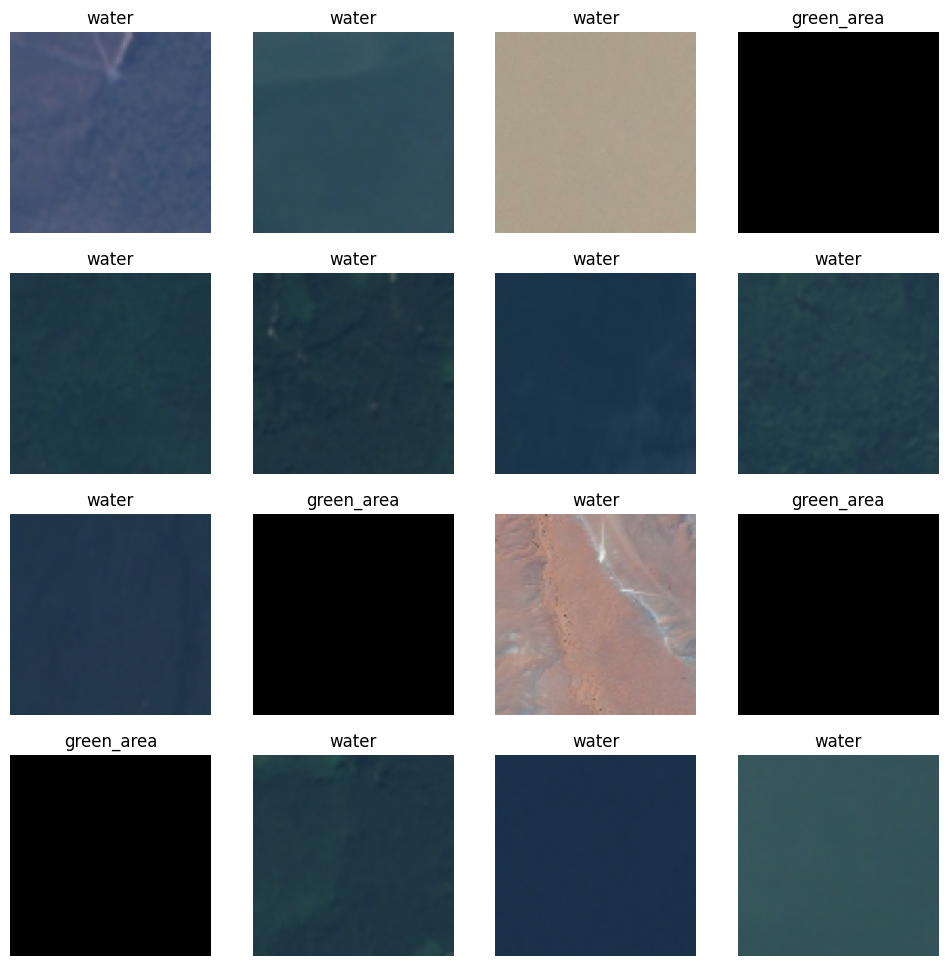

In [120]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_img.as_numpy_iterator().next()
predictions = model_newTrain.predict_on_batch(image_batch).flatten()

#Listing the classes from the data
classes_img = ['cloudy', 'desert', 'green_area', 'water']

#Prediction 
pred = model_newTrain.predict(test_img)
pred = np.argmax(pred, axis=1)
print(classes_img[pred[0]])

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 2, 3)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(classes_img[predictions[i]])
  plt.axis("off")

All four different approaches hold differring values of accuracy and loss, with loss decreasing and accuracy improving for each epoch until they are close. The sequential model held a fairly good accuracy value and was improved with the CNN approach. Unfortunately, the RNN model is not working or takes too long to compile and process, despite changing valued and adding or removing layers to allow it to run. Transferred learning is a convenient way to create a new model based off a pretrained one, although this pretrained model produced a lower accuracy result compared to the regular sequential model, it does to seem to have a good prediction based on results. Overall, the CNN model gave a great improvement and produced a good result for the overall accuracy.